In [ ]:
%load_ext autoreload
%autoreload 2
# this only works on startup!
from jax import config
config.update("jax_enable_x64", True)

import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID" 
os.environ["CUDA_VISIBLE_DEVICES"] = '3'
from gpu_utils import limit_gpu_memory_growth
limit_gpu_memory_growth()

from cleanplots import *
from tqdm import tqdm
from information_estimation import *
from image_utils import *
from gaussian_process_utils import *
from plot_utils import *

from led_array.bsccm_utils import *
from bsccm import BSCCM
from jax import jit
import numpy as onp
import jax.numpy as np

bsccm = BSCCM('/home/hpinkard_waller/data/BSCCM/')

In [74]:
# load images, extract patches, and compute cov mats
edge_crop = 32
patch_size = 10
num_images = 10000
num_patches = 10000
channel = 'LED119'
eigenvalue_floor = 1e-3

num_test_images = 1000

all_images = load_bsccm_images(bsccm, channel=channel, num_images=num_images + num_test_images, edge_crop=edge_crop, median_filter=False)
images = all_images[:num_images]
test_images = all_images[num_images:]


In [75]:
patch_sizes = [1, 2, 3, 5, 10, 20, 50]

# load train and test patches corresponding to the biggest patch size
patches = extract_patches(images, patch_sizes[-1], num_patches=num_patches, seed=0, verbose=True)
test_patches = extract_patches(test_images, patch_sizes[-1], num_patches=num_test_images, seed=0, verbose=True)

mi_estimates = {}
cov_mats = {}
mean_vecs = {}
test_set_likelihoods = {}
for patch_size in tqdm(patch_sizes):
    # take a random sub crop from the patchs
    subpatches = extract_patches(patches, patch_size, num_patches=num_patches, seed=0, verbose=False)
    test_subpatches = extract_patches(test_patches, patch_size, num_patches=num_test_images, seed=0, verbose=False)

    mi, cov_mat, mean = estimate_mutual_information(subpatches, eigenvalue_floor=eigenvalue_floor, 
                    use_iterative_optimization=True, return_cov_mat_and_mean=True, verbose=True)
    mi_estimates[patch_size] = mi
    cov_mats[patch_size] = cov_mat
    mean_vecs[patch_size] = mean
    test_set_likelihoods[patch_size] = compute_stationary_log_likelihood(test_subpatches, cov_mat, mean).mean()


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Initial loss:  6.2815103032524755
\Optimized loss:  6.28151028678973615103003929554
Estimated H(Y|X) = 6.302 bits/pixel
Estimated H(Y) = 9.083 bits/pixel
Estimated I(Y;X) = 2.781 bits/pixel


precomputing masks and variances: 100%|██████████| 1/1 [00:00<00:00, 645.97it/s]

evaluating likelihood



 14%|█▍        | 1/7 [01:50<11:01, 110.18s/it]

Initial loss:  5.4261129543873174


/home/hpinkard_waller/GitRepos/EncodingInformation/gaussian_process_utils.py:527: UserWarning: Optimization did not improve the validation loss, returning initial covariance matrix
  


\Optimized loss:  5.426114108125139
Estimated H(Y|X) = 6.298 bits/pixel
Estimated H(Y) = 7.734 bits/pixel
Estimated I(Y;X) = 1.435 bits/pixel


precomputing masks and variances: 100%|██████████| 2/2 [00:00<00:00, 553.96it/s]


evaluating likelihood


 29%|██▊       | 2/7 [03:32<08:47, 105.57s/it]

Initial loss:  4.9799555555627375
\Optimized loss:  4.97994456576724799784349458265
Estimated H(Y|X) = 6.298 bits/pixel
Estimated H(Y) = 7.214 bits/pixel
Estimated I(Y;X) = 0.915 bits/pixel


precomputing masks and variances: 100%|██████████| 3/3 [00:00<00:00, 517.64it/s]

evaluating likelihood



 43%|████▎     | 3/7 [05:51<08:03, 120.95s/it]

Initial loss:  4.724607967669108
\Optimized loss:  4.72457752442652924577524426531
Estimated H(Y|X) = 6.297 bits/pixel
Estimated H(Y) = 6.828 bits/pixel
Estimated I(Y;X) = 0.532 bits/pixel


precomputing masks and variances: 100%|██████████| 5/5 [00:00<00:00, 219.27it/s]

evaluating likelihood



 57%|█████▋    | 4/7 [08:46<07:06, 142.03s/it]

Initial loss:  4.542210076096141
\Optimized loss:  4.54211086675024242110866750244
Estimated H(Y|X) = 6.303 bits/pixel
Estimated H(Y) = 6.568 bits/pixel
Estimated I(Y;X) = 0.266 bits/pixel


precomputing masks and variances: 100%|██████████| 10/10 [00:00<00:00, 163.70it/s]

evaluating likelihood



 71%|███████▏  | 5/7 [12:04<05:24, 162.23s/it]

Initial loss:  4.450052366216818
\Optimized loss:  4.44997758575380549977585753804
Estimated H(Y|X) = 6.309 bits/pixel
Estimated H(Y) = 6.426 bits/pixel
Estimated I(Y;X) = 0.117 bits/pixel


precomputing masks and variances: 100%|██████████| 20/20 [00:00<00:00, 72.48it/s]


evaluating likelihood


 86%|████████▌ | 6/7 [16:32<03:18, 198.19s/it]

Initial loss:  5558.909809745833
\Optimized loss:  4.42129447295466319162991315195
Estimated H(Y|X) = 6.301 bits/pixel
Estimated H(Y) = 6.399 bits/pixel
Estimated I(Y;X) = 0.097 bits/pixel


precomputing masks and variances: 100%|██████████| 50/50 [00:01<00:00, 30.66it/s]


evaluating likelihood


100%|██████████| 7/7 [28:20<00:00, 242.99s/it]


[Text(0.5, 0, 'Patch size'),
 Text(0, 0.5, 'Estimated information (bits per pixel)'),
 (0.0, 3.05958853025634)]

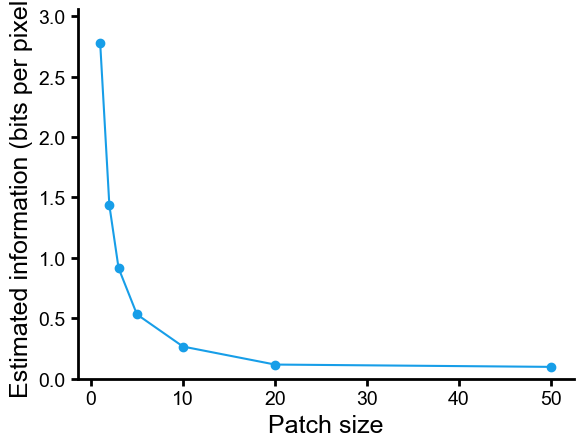

In [76]:
# Mutual information vs patch size
fig, ax = plt.subplots()
ax.plot(patch_sizes, [mi_estimates[ps] for ps in patch_sizes], 'o-')
clear_spines(ax)
ax.set(xlabel='Patch size', ylabel='Estimated information (bits per pixel)', ylim=[0, 1.1 * max(mi_estimates.values())])

precomputing masks and variances: 100%|██████████| 80/80 [02:15<00:00,  1.70s/it]


generating samples


precomputing masks and variances: 100%|██████████| 80/80 [02:31<00:00,  1.90s/it]


generating samples


precomputing masks and variances: 100%|██████████| 80/80 [02:31<00:00,  1.89s/it]


generating samples


precomputing masks and variances: 100%|██████████| 80/80 [02:31<00:00,  1.89s/it]


generating samples


precomputing masks and variances: 100%|██████████| 80/80 [02:57<00:00,  2.22s/it]


generating samples


precomputing masks and variances: 100%|██████████| 80/80 [04:35<00:00,  3.44s/it]


generating samples


precomputing masks and variances: 100%|██████████| 80/80 [10:57<00:00,  8.22s/it]


generating samples


100%|██████████| 80/80 [01:29<00:00,  1.11s/it]


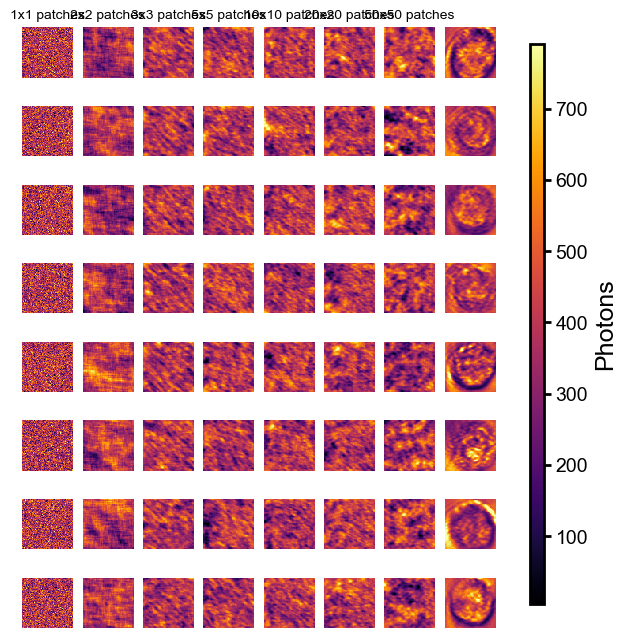

In [77]:
num_samples = 8
sample_size = 80

samples = {}
for patch_size in patch_sizes:
    samples[patch_size] = generate_stationary_gaussian_process_samples(mean_vecs[patch_size], cov_mats[patch_size], 
                                                                    num_samples=num_samples, sample_size=sample_size, prefer_iterative_sampling=False, seed=None)


fig, axs = plt.subplots(num_samples, len(patch_sizes) + 1, figsize=( len(patch_sizes), num_samples ), sharex=True, sharey=True)
vmin, vmax = np.percentile(samples[patch_sizes[0]][0], .1), np.percentile(samples[patch_sizes[0]][0], 99.9)
for j, patch_size in enumerate(patch_sizes):
    for i in range(num_samples):
        im = axs[i, j].imshow(samples[patch_size][i], cmap='inferno', vmin=vmin, vmax=vmax, interpolation='none')
        axs[i, j].axis('off')

# show ground truth patch
display_patches = extract_patches(images, sample_size, num_patches=num_samples, seed=7)
for i in range(num_samples):
    axs[i, -1].imshow(display_patches[i], cmap='inferno', vmin=vmin, vmax=vmax, interpolation='none')
    axs[i, -1].axis('off')

# add colorbar
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
fig.colorbar(im, cax=cbar_ax)
cbar_ax.set_ylabel('Photons')

# add a label to each col
for j, patch_size in enumerate(patch_sizes):
    axs[0, j].set_title(f'{patch_size}x{patch_size} patches', fontsize=10)

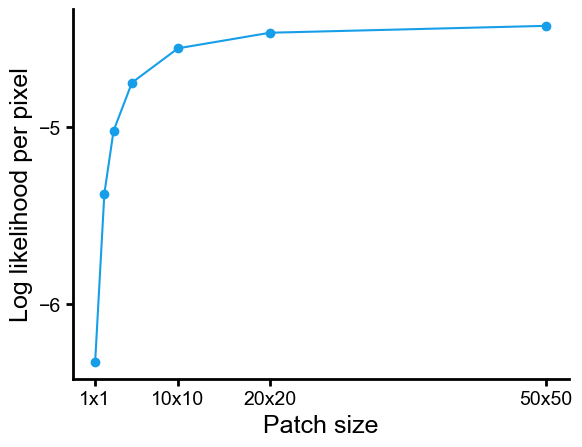

In [78]:
from matplotlib.ticker import MaxNLocator

fig, ax = plt.subplots()
log_likelihood_per_pixel = [test_set_likelihoods[ps] / (ps ** 2) for ps in patch_sizes]

ax.plot(patch_sizes, log_likelihood_per_pixel, 'o-')
clear_spines(ax)
ax.set(xlabel='Patch size', ylabel='Log likelihood per pixel')

ticks = [1, 10, 20, 50]
ax.set(xticks= ticks, xticklabels=[f'{ps}x{ps}' for ps in ticks], ylabel='Log likelihood per pixel')
ax.yaxis.set_major_locator(MaxNLocator(integer=True))
